# Projeto de regressão de ciência de dados: Previsão de preços de imóveis em Banglore

* são as coisas que um potencial comprador de casa considera antes de comprar uma casa? A localização, o tamanho da propriedade, a proximidade de escritórios, escolas, parques, restaurantes, hospitais ou a cerca branca estereotipada? E quanto ao fator mais importante - o preço?

* Comprar uma casa, especialmente em uma cidade como Bangalore, é uma escolha complicada. Embora os principais fatores sejam geralmente os mesmos para todos os metrôs, há outros a serem considerados para o Vale do Silício da Índia. Com a ajuda de uma multidão milenar, cultura vibrante, ótimo clima e uma enorme quantidade de oportunidades de trabalho, é difícil determinar o preço de uma casa em Bangalore.

Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 

link da base de dados:https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

Carregando o dataset

In [2]:
data1= pd.read_csv("/content/Bengaluru_House_Data.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/Bengaluru_House_Data.csv'

Visualizando o dataset

In [ ]:
data1.head(20)

Conferindo o shape do dataset

In [ ]:
data1.shape

Excluindo os atributos irrelevantes

In [ ]:
data2 = data1.drop(['area_type','society','balcony'],axis=1)
data2.shape

Limpeza de dados:Excluindo valores nulos

In [ ]:
data2.isnull().sum()

In [ ]:
data2.shape

In [ ]:
data3=data2.dropna()
data3.isnull().sum()

**Engenharia de dados**
* Adicionar uma nova coluna chamada br(bedroom/quartos)

In [ ]:
data3['br'] = data3['size'].apply(lambda x: int(x.split(' ')[0]))
data3.br.unique()

Checando a coluna "total_sqft"

In [ ]:
data3.head(50)

Verificando se existe outras linhas com o mesmo problema da linha 30

In [ ]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [ ]:
data3[~data3['total_sqft'].apply(is_float)].head(10)

Aqui nesse caso vamos tirar a média da coluna "total_sqft" em que se apresenta dois valores,e os valores que estão em outras unidades de medida,irei apenas excluir.

In [ ]:
def pegando_a_media_sqft(x):
    valores = x.split('-')
    if len(valores) == 2:
        return (float(valores[0])+float(valores[1]))/2
    try:
        return float(x)
    except:
        return None   

In [ ]:
data3.shape

In [ ]:
data4 = data3.copy()
data4.total_sqft = data4.total_sqft.apply(pegando_a_media_sqft)
data4 = data4[data4.total_sqft.notnull()]
data4.head()

In [ ]:
data4.shape

Verificando se a função fez a media dos valores na coluna "total_sqft"

In [ ]:
data4.loc[30]

adicionando uma nova coluna chamada preço por metro quadrado



In [ ]:
data5 = data4.copy()
data5['price_per_sqft'] = data5['price']*1000000/data5['total_sqft']
data5.head()

exportando o arquivo para excel pra conseguir fazer uma analise mais detalhada

In [ ]:
data5.to_csv("bhp.csv",index=False)

verificando a coluna "location" pra ver a quantidade de valores diferentes

In [ ]:
data5.location = data5.location.apply(lambda x: x.strip())
location_stats = data5['location'].value_counts(ascending=False)
location_stats

localizações que aparece mais de 10x

In [ ]:
len(location_stats[location_stats>10])


In [ ]:
len(location_stats[location_stats<=10])

juntando todas as localizações que aparecem menos de 10x em um valor:"outros"

In [ ]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

In [ ]:
data5.location = data5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(data5.location.unique())

In [ ]:
data5.head()

Analisando a coluna availability

In [ ]:
availability_stats = data5['availability'].value_counts(ascending=False)
availability_stats

Dividindo a coluna "availability" em dois valores:Disponivel e Indisponivel

In [ ]:
def verificando_disponibilidade(x):
    disponibilidade = x.strip()
    y='Unavailable'
    if disponibilidade == "Ready To Move":
        return x
    else:
        return y

In [ ]:
data6 = data5.copy()
data6.availability = data6.availability.apply(verificando_disponibilidade)
data6.head(10)

Verificando se teve algum problema na transformação dos dados

Sem problemas!Podemos continuar.

Removendo outliers:br_per_sqft e total_qsft

In [ ]:
data6.shape

Vamos procurar qual a média de quartos por sqft e depois remover os outleirs .

In [ ]:
data6['br_per_sqft'] = data5['total_sqft']/data6['br']
data6.head()

In [ ]:
data6.br_per_sqft.describe()

Como podemos perceber o dataset está desbalanceado,enquanto tem lugares que a prorpoção é de 4 quartos por 1 sqft.Em outros lugares a prorpoção é de 26.136 sqft por 1 quarto.Então vamos usar o método IQR(A variação interquarti)para identifcar e excluir os outliers.

In [ ]:
Q1 = data6.br_per_sqft.quantile(0.25)
Q3 = data6.br_per_sqft.quantile(0.75)
IQR = Q3 - Q1
data6.br_per_sqft= data6.br_per_sqft[~((data6.br_per_sqft < (Q1 - 1.5 * IQR)) |(data6.br_per_sqft > (Q3 + 1.5 * IQR)))]
data7=data6.dropna()

In [ ]:
data7.br_per_sqft.describe()

Nós eliminamos mais 1361 outliers

In [ ]:
data7.shape

In [ ]:
print(13200-11839)

Removendo outliers por meio da location e do price_per_sqft.Vamos comparar,se temos algum imóvel,que esteja na mesma localização e que tenha 3 quartos, com um imóvel de 2 quartos.Para conseguir ver,se na memsa localização e com mais quartos,tenha um preço por sqft igual ou menor do que um imóvel com menos quartos.Para isso vamos pegar duas das cinco localizações mais recorrentes:Thanisandra e Electronic City.

In [ ]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.br==2)]
    bhk3 = df[(df.location==location) & (df.br==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK')
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK')
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(data7,"Hebbal")

Como podemos ver,existem alguns imóveis de 3 quartos que mesmo tendo o tamanho e localização iguais,são mais baratos do que alguns imóveis de 2 quartos.bom,como isso,muito provavelmente são outliers, iremos removê-los.

In [ ]:
plot_scatter_chart(data7,"Rajaji Nagar")

Criando uma função para remover os outlierts

In [ ]:
def remove_br_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        br_stats = {}
        for br, br_df in location_df.groupby('br'):
            br_stats[br] = {
                'mean': np.mean(br_df.price_per_sqft),
                'std': np.std(br_df.price_per_sqft),
                'count': br_df.shape[0]
            }
        for br, br_df in location_df.groupby('br'):
            stats = br_stats.get(br-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, br_df[br_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
data8 = remove_br_outliers(data7)
data8.shape

O que acontece nessa função é basicamente o seguinte.Estamos criando um dicionário que vai mostrar a média,o desvio padrão e quantidade de imóveis por o número de quartos,tods na mesmaslocalização.Se o "preço por metro "de algum imóvel nesse dicionario for menor do que a média,dos outros imóveis com as mesmas característica,o imóvel será removido.

Exemplo de como ficaria:


    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    


In [ ]:
plot_scatter_chart(data8,"Hebbal")

In [ ]:
adc=plot_scatter_chart(data8,"Rajaji Nagar")

**Antes & Depois Hebbal**

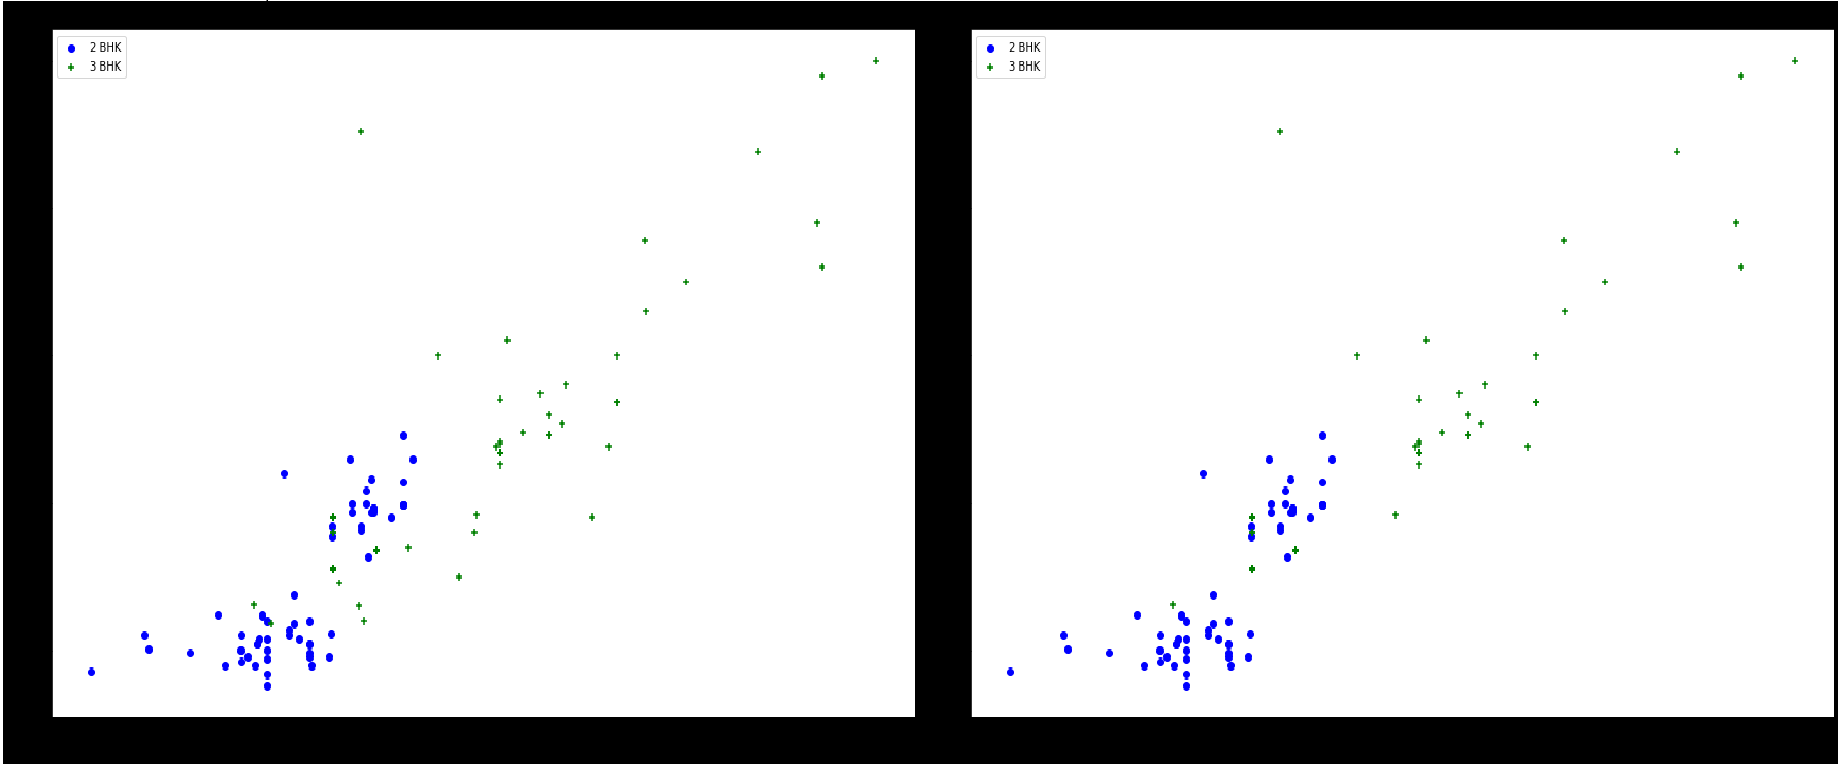

**Antes & Depois Rajaji Nagar**

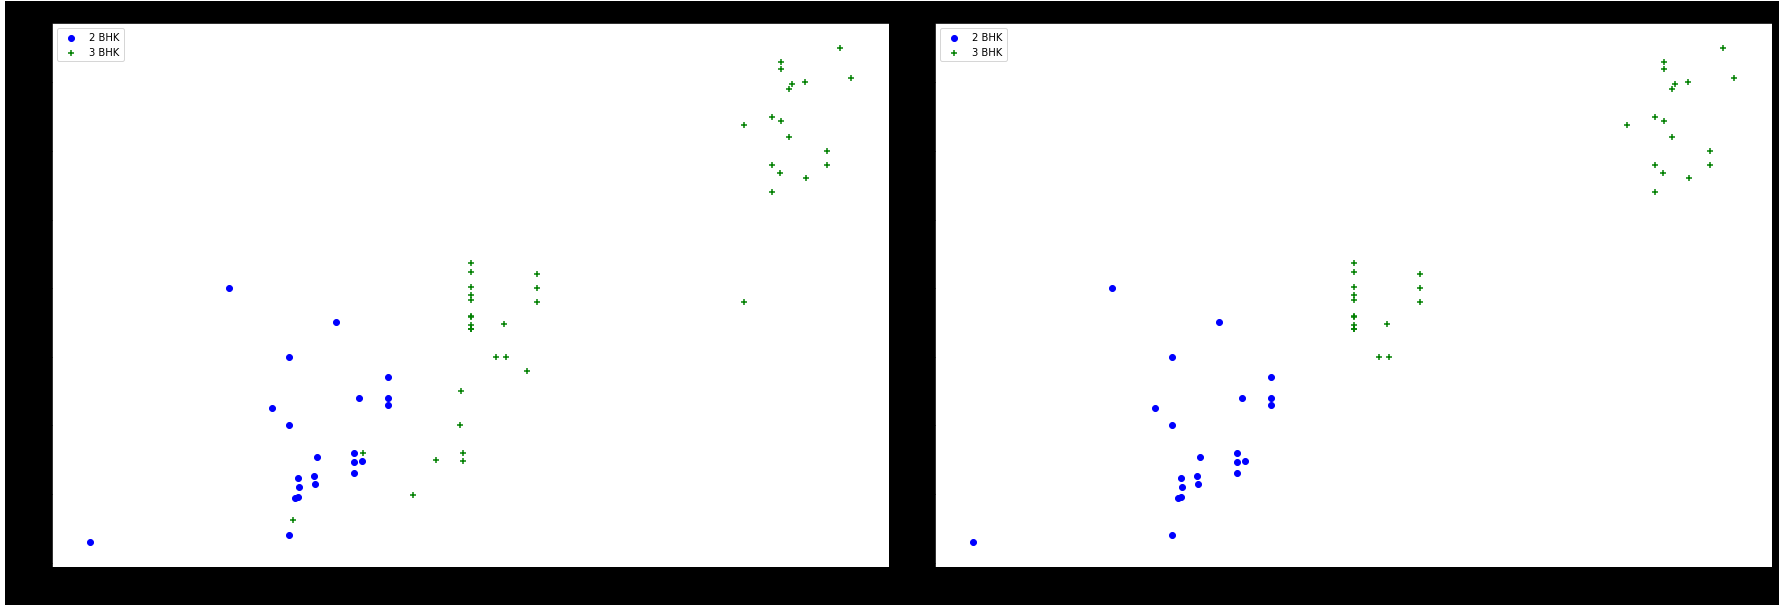

Removendo outliers da variável bathrooms

In [ ]:
plt.hist(data8.bath,rwidth=0.5)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

Vamos excluir os dados que o numero de banheiros mais 2 é maior que o numero de quartos.

In [ ]:
data8[data8.bath>data8.br+2].head(10)

In [ ]:
data9 = data8[data8.bath<data8.br+2]
data9.shape

Vamos exluir colunas,que só foram usadas,para nos ajudar com o entendimento do dataset(price_per_sqft e br_per_sqft).E para a coluna 'size' ja foi criada a coluna 'br'

In [ ]:
data10 = data9.drop(['size','price_per_sqft','br_per_sqft'],axis='columns')
data10.head(3)

Engenharia de dados:Transformando a variável categórica"availability",em números,1 para 'Ready To Move' e  para 'Unavailable'.

In [ ]:
data11=data10.copy()
data11['availability']=data10['availability'].map({'Ready To Move':1, 'Unavailable':0})

In [ ]:
data11

Checando se os dados estão com problemas de distribuição

In [ ]:
data11.skew(axis = 0, skipna = True)

* assimetria = 0 : distribuição normal.
* assimetria > 0 : mais peso na cauda esquerda da distribuição.
* assimetria < 0 : mais peso na cauda direita da distribuição.

A variável price está assimétrica,vamos usar o método IQR,para solucionar o problema.

In [ ]:
Q1 = data11.price.quantile(0.25)
Q3 = data11.price.quantile(0.75)
IQR = Q3 - Q1
data11.price= data11.price[~((data11.price < (Q1 - 1.5 * IQR)) |(data11.price > (Q3 + 1.5 * IQR)))]
data11=data11.dropna()


In [ ]:
data11.price.skew(axis = 0, skipna = True)

In [ ]:
data11.shape

Visualizando as correlações das variáveis

In [ ]:
correlations = data11.corr()
correlations

Fazendo one hot enconding na variável "location"

In [ ]:
dummies_location = pd.get_dummies(data11.location)
dummies_location.head(3)

Juntando o dataset mais o dummies da coluna "location"

In [ ]:
data12 = data11.drop('location',axis='columns')
data12.head(2)

In [ ]:
data12 = pd.concat([data12,dummies_location.drop('other',axis='columns')],axis='columns')
data12.head()

a coluna availability,tem uma relação muito pequena com o output "price".Por isso iremos excluir a coluna.

In [ ]:
data12=data12.drop('availability',axis='columns')

Construindo uma máquina preditiva de regressão

In [ ]:
data12.shape

In [ ]:
X = data12.drop(['price'],axis='columns')
X.shape

In [ ]:
y = data12.price
y.head

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=39)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
#GB=GradientBoostingRegressor(learning_rate=0.06826323829884362, max_depth=5,n_estimators=999, subsample=0.8386912944636394)

Testando quais modelos vão obter a melhor média,usando o r2_score como parâmetro.

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=39)

media =cross_val_score(LinearRegression(), X, y, cv=cv).mean()

media


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=39)

media =cross_val_score(GradientBoostingRegressor(), X, y, cv=cv).mean()

media

In [ ]:
import xgboost as xgb
xgb_reg=xgb.XGBRegressor()

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=39)

media =cross_val_score(xgb_reg, X, y, cv=cv).mean()

media

In [ ]:
import lightgbm as lgb
lgb_reg=lgb.LGBMRegressor()

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=39)

media =cross_val_score(lgb_reg, X, y, cv=cv).mean()

media

o modelo escolhido para o tuning foi o GradientBoostingRegressor,atingindo um resultado de %.Agora vamos melhorar o resultado tunando os hiperparâmetros,usando o método Randomizedsearch

In [ ]:
import scipy
from scipy.stats import loguniform
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt


Vamos usar o Randomizedsearch para melhores resultados do nosso modelo 





In [ ]:
"""

model = GradientBoostingRegressor()
parameters = {'learning_rate': sp_randFloat(),
                  'subsample'    : sp_randFloat(),
                  'n_estimators' : sp_randInt(100, 1000),
                  'max_depth'    : sp_randInt(4, 20)}
randm_src = RandomizedSearchCV(estimator=model, param_distributions = parameters,
                               cv = 2, n_iter = 50, n_jobs=-1)
randm_src.fit(X_train, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

"""


Melhor resultado

In [ ]:
#GradientBoostingRegressor(learning_rate = 0.06677377542851048, max_depth = 5,n_estimators = 684, subsample = 0.9705354925313132)

tivemos uma melhora considerável de 71% para 75%

Fazendo o fit do modelo

In [ ]:
from sklearn.linear_model import LinearRegression
gb = GradientBoostingRegressor(learning_rate = 0.06677377542851048, max_depth = 7,n_estimators = 728, subsample = 0.9705354925313132,random_state=39)
gb.fit(X_train,y_train)
gb.score(X_test,y_test)

In [ ]:
   def predict_price(location,sqft,bath,br):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = br
    if loc_index >= 0:
        x[loc_index] = 1

    return gb.predict([x])[0]

In [ ]:
  predict_price('1st Phase JP Nagar',1000, 2, 2)